In [41]:
import json
import requests
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['axes.grid'] = True
import pandas as pd
import seaborn as sns 
import itertools
import time
from oaipmh.client import Client
from oaipmh.metadata import MetadataRegistry, oai_dc_reader

In [42]:
max_dataset = 500
fuji_service = 'http://localhost:1071/fuji/api/v1/evaluate'
data_dir = 'results'

Request metric defs

In [43]:
metrics = []
try:
    request = requests.get('http://localhost:1071/fuji/api/v1/metrics',headers={'Content-Type': 'application/json'}, auth=('username', 'password'))
    mm = request.json()['metrics']
    for m in mm:
        metrics.append({k: m[k] for k in ('metric_identifier', 'metric_name', 'total_score')})
except requests.exceptions.RequestException as e:
    print(e)
except requests.exceptions.ConnectionError as e1:
    print(e1)

In [44]:
df_metrics = pd.DataFrame.from_dict(metrics)
df_metrics

,metric_identifier,metric_name,total_score
0,FsF-F1-01D,Data is assigned a globally unique identifier.,1
1,FsF-F1-02D,Data is assigned a persistent identifier.,1
2,FsF-F2-01M,"Metadata includes descriptive core elements (creator, title, data identifier, publisher, publication date, summary and keywords) to support data findability.",2
3,FsF-F3-01M,Metadata includes the identifier of the data it describes.,1
4,FsF-F4-01M,Metadata is offered in such a way that it can be retrieved programmatically.,2
5,FsF-A1-01M,Metadata contains access level and access conditions of the data.,1
6,FsF-A1-02MD,Metadata as well as data are retrievable by their identifier using a standardized communications protocol.,2
7,FsF-A2-01M,"Metadata remains available, even if the data is no longer available.",1
8,FsF-I1-01M,Metadata is represented using a formal knowledge representation language.,2
9,FsF-I1-02M,Metadata uses semantic resources,1


Request phaidra italy records

In [45]:
datasets = []
oai_phaidra = 'https://fc.cab.unipd.it/oaiprovider/'

In [46]:
oai_sets =[]
registry = MetadataRegistry()
registry.registerReader('oai_dc', oai_dc_reader)
client = Client(oai_phaidra, registry)
for s in client.listSets():
    oai_sets.append(s[0])

In [47]:
oai_sets

['fisica',
 'tavole-parietali-anonime',
 'zoologische-wandtafeln-leuckart',
 'zoologische-wandtafeln-leuckart-nitsche',
 'zoologische-wandtafeln-pfurtscheller',
 'collection-remy-perrier-cepede',
 'BELF',
 'PSMC']

In [48]:
for s in oai_sets:
    i=0
    registry = MetadataRegistry()
    registry.registerReader('oai_dc', oai_dc_reader)
    client = Client(oai_phaidra, registry)
    for record in client.listRecords(metadataPrefix='oai_dc', set=s):
        #print(record[0].identifier())
        metadata = record[1].getMap()
        if 'identifier' in metadata:
            for d in metadata['identifier']: #https://hdl.handle.net/11168/11.109550
                if d.startswith('hdl:'):
                    iden = d.replace('hdl:','https://hdl.handle.net/')
                    datasets.append(iden)
        i += 1
    print(s, ':', i)

fisica : 13
tavole-parietali-anonime : 95
zoologische-wandtafeln-leuckart : 29
zoologische-wandtafeln-leuckart-nitsche : 31
zoologische-wandtafeln-pfurtscheller : 18
collection-remy-perrier-cepede : 16
BELF : 92
PSMC : 61


In [49]:
len(datasets)

355

In [50]:
datasets = list(set(datasets))
len(datasets)

355

In [51]:
datasets[:5]

['https://hdl.handle.net/11168/11.12766',
 'https://hdl.handle.net/11168/11.145401',
 'https://hdl.handle.net/11168/11.100687',
 'https://hdl.handle.net/11168/11.351684',
 'https://hdl.handle.net/11168/11.351777']

In [52]:
timestr = time.strftime("%Y%m%d")
timestr

'20200910'

In [53]:
%%time 
all_records = []
for d in datasets:
    req = {'object_identifier':d, 'test_debug':True, 'oaipmh_endpoint':oai_phaidra}
    r = requests.post(fuji_service, data=json.dumps(req), headers={'Content-Type': 'application/json'}, auth=('username', 'password'))
    json_data = r.json()
    records = {}
    records['identifier'] = d
    records['result'] = json_data
    all_records.append(records)

Wall time: 43min 37s


In [54]:
#file_name = data_dir+'/'+'phaidraitaly_'+timestr+'.json'
with open(file_name, 'w') as f:
    json.dump(all_records, f)

In [55]:
file_name ='results/phaidraitaly_20200908.json'
with open(file_name) as json_file:
    data = json.load(json_file)

In [56]:
def get_assessment_result(id):
    jsn = None
    for data_dict in data:
        if data_dict['identifier'] == id:
            jsn = data_dict['result']
    return jsn

In [57]:
test_dataset ='https://hdl.handle.net/11168/11.12734'

In [58]:
get_assessment_result(test_dataset)

[{'id': 1,
  'metric_identifier': 'FsF-F1-01D',
  'metric_name': 'Data is assigned a globally unique identifier.',
  'output': {'guid': 'https://hdl.handle.net/11168/11.12734',
   'guid_scheme': 'handle'},
  'score': {'earned': 1, 'total': 1},
  'test_debug': ["INFO: Unique identifier schemes found ['handle', 'url']",
   'INFO: Finalized unique identifier scheme - handle'],
  'test_status': 'pass'},
 {'id': 2,
  'metric_identifier': 'FsF-F1-02D',
  'metric_name': 'Data is assigned a persistent identifier.',
  'output': {'pid': 'https://hdl.handle.net/11168/11.12734',
   'pid_scheme': 'handle',
   'resolvable_status': True,
   'resolved_url': 'https://phaidra.cab.unipd.it/view/o:12734'},
  'score': {'earned': 1, 'total': 1},
  'test_debug': ['INFO: Persistence identifier scheme - handle',
   'INFO: Retrieving page http://hdl.handle.net/11168/11.12734',
   'INFO: Content negotiation accept=text/html, application/xhtml+xml, status=200',
   'INFO: Found HTML page!',
   'INFO: Object identi

In [59]:
final = []
for data_dict in data:
    results = {}
    results['identifier'] = data_dict['identifier']
    dd = data_dict['result'] # list of dict
    #print(results['identifier'])
    for d in dd:
        metric_identifier = d['metric_identifier']
        sub_principle = metric_identifier.split('-')[1]
        principle = sub_principle[0]+'_earned'
        principle_total = sub_principle[0]+'_total'
        if not sub_principle in results:
            results[sub_principle] = d['score']['earned']
        else:
            results[sub_principle] += d['score']['earned']
        if not principle in results:
            results[principle] = d['score']['earned']
        else:
            results[principle] += d['score']['earned']
        if not principle_total in results:
            results[principle_total] = d['score']['total']
        else:
            results[principle_total] += d['score']['total']
    final.append(results)

In [60]:
df_results = pd.DataFrame.from_dict(final)

In [61]:
cols = ['identifier','F1','F2','F3','F4','A1','A1','I1','I3','R1','R1.1','R1.2','R1.3','F_earned','F_total','A_earned','A_total','I_earned','I_total','R_earned','R_total']
df_results = df_results[cols]

In [62]:
df_results.head()

,identifier,F1,F2,F3,F4,A1,A1,I1,I3,R1,...,R1.2,R1.3,F_earned,F_total,A_earned,A_total,I_earned,I_total,R_earned,R_total
0,https://hdl.handle.net/11168/11.12766,2,0,0,0,0,0,0,0,0,...,0,1,2,7,0,1,0,4,1,9
1,https://hdl.handle.net/11168/11.145401,2,0,0,0,0,0,0,0,0,...,0,1,2,7,0,1,0,4,1,9
2,https://hdl.handle.net/11168/11.100687,2,0,0,0,0,0,0,0,0,...,0,1,2,7,0,1,0,4,1,9
3,https://hdl.handle.net/11168/11.351684,2,0,0,0,0,0,0,0,0,...,0,1,2,7,0,1,0,4,1,9
4,https://hdl.handle.net/11168/11.351777,2,0,0,0,0,0,0,0,0,...,0,1,2,7,0,1,0,4,1,9


In [63]:
df_results ['F_Principle'] = (df_results ['F_earned'] / df_results ['F_total'] ).round(2)
df_results ['A_Principle'] = (df_results ['A_earned'] / df_results ['A_total'] ).round(2)
df_results ['I_Principle'] = (df_results ['I_earned'] / df_results ['I_total'] ).round(2)
df_results ['R_Principle' ]= (df_results ['R_earned'] / df_results ['R_total']).round(2)

In [64]:
df_results.head()

,identifier,F1,F2,F3,F4,A1,A1,I1,I3,R1,...,A_earned,A_total,I_earned,I_total,R_earned,R_total,F_Principle,A_Principle,I_Principle,R_Principle
0,https://hdl.handle.net/11168/11.12766,2,0,0,0,0,0,0,0,0,...,0,1,0,4,1,9,0.29,0.0,0.0,0.11
1,https://hdl.handle.net/11168/11.145401,2,0,0,0,0,0,0,0,0,...,0,1,0,4,1,9,0.29,0.0,0.0,0.11
2,https://hdl.handle.net/11168/11.100687,2,0,0,0,0,0,0,0,0,...,0,1,0,4,1,9,0.29,0.0,0.0,0.11
3,https://hdl.handle.net/11168/11.351684,2,0,0,0,0,0,0,0,0,...,0,1,0,4,1,9,0.29,0.0,0.0,0.11
4,https://hdl.handle.net/11168/11.351777,2,0,0,0,0,0,0,0,0,...,0,1,0,4,1,9,0.29,0.0,0.0,0.11


In [65]:
df_hist = df_results[['identifier','F_Principle','A_Principle','I_Principle','R_Principle']]
df_hist

,identifier,F_Principle,A_Principle,I_Principle,R_Principle
0,https://hdl.handle.net/11168/11.12766,0.29,0.0,0.0,0.11
1,https://hdl.handle.net/11168/11.145401,0.29,0.0,0.0,0.11
2,https://hdl.handle.net/11168/11.100687,0.29,0.0,0.0,0.11
3,https://hdl.handle.net/11168/11.351684,0.29,0.0,0.0,0.11
4,https://hdl.handle.net/11168/11.351777,0.29,0.0,0.0,0.11
...,...,...,...,...,...
350,https://hdl.handle.net/11168/11.12773,0.29,0.0,0.0,0.11
351,https://hdl.handle.net/11168/11.353294,0.29,0.0,0.0,0.11
352,https://hdl.handle.net/11168/11.353291,0.29,0.0,0.0,0.11
353,https://hdl.handle.net/11168/11.353314,0.29,0.0,0.0,0.11


In [66]:
df_hist[df_hist.F_Principle <50].iloc[0]

identifier     https://hdl.handle.net/11168/11.12766
F_Principle                                     0.29
A_Principle                                        0
I_Principle                                        0
R_Principle                                     0.11
Name: 0, dtype: object

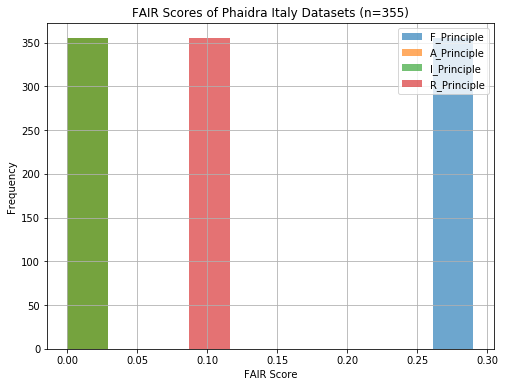

In [67]:
#timestr ='20200908'
title = "FAIR Scores of Phaidra Italy Datasets (n="+str(len(df_hist))+")"
df_hist.plot.hist(sharex=True,sharey=True,alpha=0.65,figsize = (8,6), title=title)
plt.xlabel('FAIR Score')
fig_name = data_dir+'/'+'phaidraitaly_'+timestr+'.png'
plt.savefig(fig_name)

In [68]:
def histograms_plot(dataframe, features, rows, cols):
    fig=plt.figure(figsize=(8,6))
    # set palette 
    palette = itertools.cycle(sns.color_palette())
    for i, feature in enumerate(features):
        c = next(palette)
        ax=fig.add_subplot(rows,cols,i+1)
        dataframe[feature].plot.hist(bins=20, ax=ax, color=c, range=(0, 1.0))
        ax.set_title("FAIR Score - "+feature+ ' (n=' + str(len(df_hist))+')')
        ax.set(xlabel="Score", ylabel="Frequency")
    fig.subplots_adjust(top=1.4)
    plt.show()
    fig_name = data_dir+'/'+'sub_phaidraitaly_'+timestr+'.png'
    plt.savefig(fig_name)

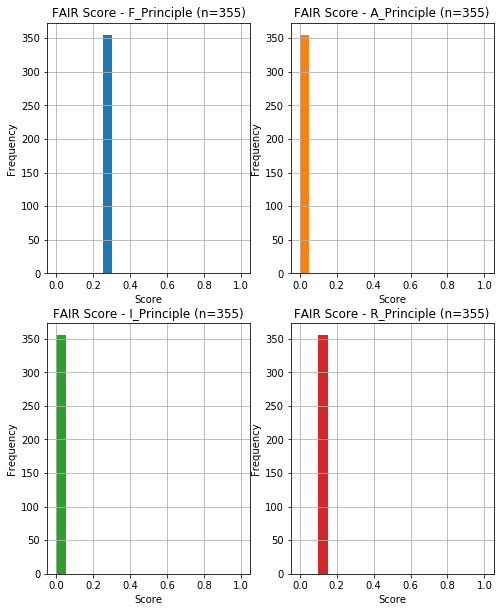

<Figure size 432x288 with 0 Axes>

In [69]:
histograms_plot(df_hist,df_hist.columns[1:],2,2)

In [70]:
pd.set_option('display.max_colwidth', None)

Findability

In [71]:
df_hist[df_hist.F_Principle < 0.9]

,identifier,F_Principle,A_Principle,I_Principle,R_Principle
0,https://hdl.handle.net/11168/11.12766,0.29,0.0,0.0,0.11
1,https://hdl.handle.net/11168/11.145401,0.29,0.0,0.0,0.11
2,https://hdl.handle.net/11168/11.100687,0.29,0.0,0.0,0.11
3,https://hdl.handle.net/11168/11.351684,0.29,0.0,0.0,0.11
4,https://hdl.handle.net/11168/11.351777,0.29,0.0,0.0,0.11
...,...,...,...,...,...
350,https://hdl.handle.net/11168/11.12773,0.29,0.0,0.0,0.11
351,https://hdl.handle.net/11168/11.353294,0.29,0.0,0.0,0.11
352,https://hdl.handle.net/11168/11.353291,0.29,0.0,0.0,0.11
353,https://hdl.handle.net/11168/11.353314,0.29,0.0,0.0,0.11


In [72]:
df_hist[df_hist.F_Principle >= 0.9].head()

,identifier,F_Principle,A_Principle,I_Principle,R_Principle


Accessibility

In [73]:
df_hist[df_hist.A_Principle < 0.6].head()

,identifier,F_Principle,A_Principle,I_Principle,R_Principle
0,https://hdl.handle.net/11168/11.12766,0.29,0.0,0.0,0.11
1,https://hdl.handle.net/11168/11.145401,0.29,0.0,0.0,0.11
2,https://hdl.handle.net/11168/11.100687,0.29,0.0,0.0,0.11
3,https://hdl.handle.net/11168/11.351684,0.29,0.0,0.0,0.11
4,https://hdl.handle.net/11168/11.351777,0.29,0.0,0.0,0.11


Interoperability

In [74]:
df_hist[df_hist.I_Principle < 0.6].head()

,identifier,F_Principle,A_Principle,I_Principle,R_Principle
0,https://hdl.handle.net/11168/11.12766,0.29,0.0,0.0,0.11
1,https://hdl.handle.net/11168/11.145401,0.29,0.0,0.0,0.11
2,https://hdl.handle.net/11168/11.100687,0.29,0.0,0.0,0.11
3,https://hdl.handle.net/11168/11.351684,0.29,0.0,0.0,0.11
4,https://hdl.handle.net/11168/11.351777,0.29,0.0,0.0,0.11


In [75]:
df_hist[df_hist.I_Principle > 0.6].head()

,identifier,F_Principle,A_Principle,I_Principle,R_Principle


Reusability

In [76]:
df_hist[df_hist.R_Principle < 0.4].head()

,identifier,F_Principle,A_Principle,I_Principle,R_Principle
0,https://hdl.handle.net/11168/11.12766,0.29,0.0,0.0,0.11
1,https://hdl.handle.net/11168/11.145401,0.29,0.0,0.0,0.11
2,https://hdl.handle.net/11168/11.100687,0.29,0.0,0.0,0.11
3,https://hdl.handle.net/11168/11.351684,0.29,0.0,0.0,0.11
4,https://hdl.handle.net/11168/11.351777,0.29,0.0,0.0,0.11


In [77]:
df_hist[df_hist.R_Principle > 0.6].head()

,identifier,F_Principle,A_Principle,I_Principle,R_Principle


In [78]:
df_hist[df_hist.R_Principle < 0.6]

,identifier,F_Principle,A_Principle,I_Principle,R_Principle
0,https://hdl.handle.net/11168/11.12766,0.29,0.0,0.0,0.11
1,https://hdl.handle.net/11168/11.145401,0.29,0.0,0.0,0.11
2,https://hdl.handle.net/11168/11.100687,0.29,0.0,0.0,0.11
3,https://hdl.handle.net/11168/11.351684,0.29,0.0,0.0,0.11
4,https://hdl.handle.net/11168/11.351777,0.29,0.0,0.0,0.11
...,...,...,...,...,...
350,https://hdl.handle.net/11168/11.12773,0.29,0.0,0.0,0.11
351,https://hdl.handle.net/11168/11.353294,0.29,0.0,0.0,0.11
352,https://hdl.handle.net/11168/11.353291,0.29,0.0,0.0,0.11
353,https://hdl.handle.net/11168/11.353314,0.29,0.0,0.0,0.11
